Boris Chen or Boris Degen?

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering
%matplotlib inline
plt.style.use('seaborn')

In [2]:
offense_df = pd.read_csv('data/nfl_pass_rush_receive_raw_data.csv')
dst_df = pd.read_csv('data/nfl_dst_raw_data.csv')
kicking_df = pd.read_csv('data/nfl_kicking_raw_data.csv')

Load data for offenses, D/STs, and kicking. <br>
First, focus on offense data. Passing and QB play specifically. <br>
Starting QBs will have established ranks and potentially clustered with k-means. <br>
Players that have attempted passes on trick plays or other special play designs will be excluded.

In [3]:
offense_df.head()

,game_id,player_id,pos,player,team,pass_cmp,pass_att,pass_yds,pass_td,pass_int,...,OT,Roof,Surface,Temperature,Humidity,Wind_Speed,Vegas_Line,Vegas_Favorite,Over_Under,game_date
0,202209080ram,AlleJo02,QB,Josh Allen,BUF,26,31,297,3,2,...,False,dome,matrixturf,72,45,0,-2.5,BUF,52.0,2022-09-08
1,202209080ram,SingDe00,RB,Devin Singletary,BUF,0,0,0,0,0,...,False,dome,matrixturf,72,45,0,-2.5,BUF,52.0,2022-09-08
2,202209080ram,MossZa00,RB,Zack Moss,BUF,0,0,0,0,0,...,False,dome,matrixturf,72,45,0,-2.5,BUF,52.0,2022-09-08
3,202209080ram,CookJa01,RB,James Cook,BUF,0,0,0,0,0,...,False,dome,matrixturf,72,45,0,-2.5,BUF,52.0,2022-09-08
4,202209080ram,DiggSt00,WR,Stefon Diggs,BUF,0,0,0,0,0,...,False,dome,matrixturf,72,45,0,-2.5,BUF,52.0,2022-09-08


In [4]:
# qbs_df = []
# for entry in offense_df:
#     if offense_df['pos']=='QB':
#         qbs_df.append(entry)


In [5]:
qbs_df = offense_df[offense_df['pos']=='QB']
# qbs_df

Apprarently 277 QB entries this season, this data reflects weeks 1-8 of the NFL 2022 regular season. <br>
32 teams * 8 games = 256 minus teams on bye so there have certainly been backups, injuries, and QB changes.

In [6]:
print(qbs_df['player'].unique())
print(len(qbs_df['player'].unique()))

['Josh Allen' 'Matthew Stafford' 'Jameis Winston' 'Taysom Hill'
 'Marcus Mariota' 'Baker Mayfield' 'Jacoby Brissett' 'Trey Lance'
 'Justin Fields' 'Joe Burrow' 'Mitchell Trubisky' 'Patrick Mahomes'
 'Kyler Murray' 'Trace McSorley' 'Dak Prescott' 'Cooper Rush' 'Tom Brady'
 'Jared Goff' 'Jalen Hurts' 'Matt Ryan' 'Davis Mills' 'Jeff Driskel'
 'Mac Jones' 'Tua Tagovailoa' 'Aaron Rodgers' 'Jordan Love' 'Kirk Cousins'
 'Lamar Jackson' 'Joe Flacco' 'Daniel Jones' 'Ryan Tannehill' 'Derek Carr'
 'Justin Herbert' 'Trevor Lawrence' 'Carson Wentz' 'Geno Smith'
 'Russell Wilson' 'Jimmy Garoppolo' 'Case Keenum' 'Malik Willis'
 'Teddy Bridgewater' 'C.J. Beathard' 'Bailey Zappe' 'Brian Hoyer'
 'Andy Dalton' 'Tyrod Taylor' 'Zach Wilson' 'Kenny Pickett' 'Brock Purdy'
 'P.J. Walker' 'Skylar Thompson' 'Jacob Eason' 'Brett Rypien' 'Chad Henne'
 'Taylor Heinicke' 'Sam Ehlinger' 'Trevor Siemian' 'Jarrett Stidham'
 'Gardner Minshew II']
59


59 QBs have made appearances this season. <br>
We will take a look at each of these players.

In [7]:
qbs_df['player'].value_counts()

Jacoby Brissett       8
Kyler Murray          8
Aaron Rodgers         8
Daniel Jones          8
Marcus Mariota        8
Justin Fields         8
Lamar Jackson         8
Joe Burrow            8
Trevor Lawrence       8
Tom Brady             8
Geno Smith            8
Jared Goff            7
Justin Herbert        7
Jalen Hurts           7
Jimmy Garoppolo       7
Patrick Mahomes       7
Josh Allen            7
Davis Mills           7
Matt Ryan             7
Kirk Cousins          7
Matthew Stafford      7
Derek Carr            7
Russell Wilson        7
Tua Tagovailoa        6
Ryan Tannehill        6
Cooper Rush           6
Carson Wentz          6
Andy Dalton           5
Zach Wilson           5
Mitchell Trubisky     5
Kenny Pickett         5
Mac Jones             5
Baker Mayfield        5
Bailey Zappe          4
Teddy Bridgewater     4
P.J. Walker           4
Jameis Winston        3
Joe Flacco            3
Dak Prescott          3
Taysom Hill           3
Trey Lance            2
Malik Willis    

Taking a look at passing yards, rushing yards, passer rating, and TD:INT rate for top QBs this season (contextual understanding and interpretation of successful teams and widely regarded QBs).

In [8]:
qbs_df.columns

Index(['game_id', 'player_id', 'pos', 'player', 'team', 'pass_cmp', 'pass_att',
       'pass_yds', 'pass_td', 'pass_int', 'pass_sacked', 'pass_sacked_yds',
       'pass_long', 'pass_rating', 'rush_att', 'rush_yds', 'rush_td',
       'rush_long', 'targets', 'rec', 'rec_yds', 'rec_td', 'rec_long',
       'fumbles_lost', 'rush_scrambles', 'designed_rush_att',
       'comb_pass_rush_play', 'comb_pass_play', 'comb_rush_play',
       'Team_abbrev', 'Opponent_abbrev', 'two_point_conv', 'total_ret_td',
       'offensive_fumble_recovery_td', 'pass_yds_bonus', 'rush_yds_bonus',
       'rec_yds_bonus', 'Total_DKP', 'Off_DKP', 'Total_FDP', 'Off_FDP',
       'Total_SDP', 'Off_SDP', 'pass_target_yds', 'pass_poor_throws',
       'pass_blitzed', 'pass_hurried', 'rush_yds_before_contact', 'rush_yac',
       'rush_broken_tackles', 'rec_air_yds', 'rec_yac', 'rec_drops', 'offense',
       'off_pct', 'vis_team', 'home_team', 'vis_score', 'home_score', 'OT',
       'Roof', 'Surface', 'Temperature', 'Humidit

In [9]:
qbs_df['total_yds'] = qbs_df['pass_yds'] + qbs_df['rush_yds']
qbs_df['total_tds'] = qbs_df['pass_td'] + qbs_df['rush_td']
# qbs_df.head()

<ipython-input-9-413857380854>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qbs_df['total_yds'] = qbs_df['pass_yds'] + qbs_df['rush_yds']
<ipython-input-9-413857380854>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qbs_df['total_tds'] = qbs_df['pass_td'] + qbs_df['rush_td']


In [10]:
joshallen_df = qbs_df[qbs_df['player']=='Josh Allen']
# joshallen_df

## Players will be displayed with their stats from here on down:

In [11]:
# wk_9_list = []
# for player in qbs_df['player']:
#     if ((qbs_df['player'].value_counts()>=6) == True).any():
#         wk_9_list.append(qbs_df['player'])
#         print(wk_9_list)
    

In [12]:
print('joshallen pass_yds: ', joshallen_df['pass_yds'].sum())
print('joshallen rush_yds: ', joshallen_df['rush_yds'].sum())
print('joshallen pass_td: ', joshallen_df['pass_td'].sum())
print('joshallen pass_int: ', joshallen_df['pass_int'].sum())
print('joshallen rush_td: ', joshallen_df['rush_td'].sum())
print('joshallen fumbles_lost: ', joshallen_df['fumbles_lost'].sum())
print('joshallen pass_rating: ', joshallen_df['pass_rating'].mean())

joshallen pass_yds:  2198
joshallen rush_yds:  306
joshallen pass_td:  19
joshallen pass_int:  6
joshallen rush_td:  2
joshallen fumbles_lost:  2
joshallen pass_rating:  104.4


In [13]:
joeburrow_df = qbs_df[qbs_df['player']=='Joe Burrow']
print('joeburrow pass_yds: ', joeburrow_df['pass_yds'].sum())
print('joeburrow rush_yds: ', joeburrow_df['rush_yds'].sum())
print('joeburrow pass_td: ', joeburrow_df['pass_td'].sum())
print('joeburrow pass_int: ', joeburrow_df['pass_int'].sum())
print('joeburrow rush_td: ', joeburrow_df['rush_td'].sum())
print('joeburrow fumbles_lost: ', joeburrow_df['fumbles_lost'].sum())
print('joeburrow pass_rating: ', joeburrow_df['pass_rating'].mean())

joeburrow pass_yds:  2329
joeburrow rush_yds:  132
joeburrow pass_td:  17
joeburrow pass_int:  6
joeburrow rush_td:  3
joeburrow fumbles_lost:  2
joeburrow pass_rating:  103.21249999999999


In [14]:
danieljones_df = qbs_df[qbs_df['player']=='Daniel Jones']
print('danieljones pass_yds: ', danieljones_df['pass_yds'].sum())
print('danieljones rush_yds: ', danieljones_df['rush_yds'].sum())
print('danieljones pass_td: ', danieljones_df['pass_td'].sum())
print('danieljones pass_int: ', danieljones_df['pass_int'].sum())
print('danieljones rush_td: ', danieljones_df['rush_td'].sum())
print('danieljones fumbles_lost: ', danieljones_df['fumbles_lost'].sum())
print('danieljones pass_rating: ', danieljones_df['pass_rating'].mean())

danieljones pass_yds:  1399
danieljones rush_yds:  363
danieljones pass_td:  6
danieljones pass_int:  2
danieljones rush_td:  3
danieljones fumbles_lost:  2
danieljones pass_rating:  89.37499999999999


In [15]:
kylermurray_df = qbs_df[qbs_df['player']=='Kyler Murray']
print('kylermurray pass_yds: ', kylermurray_df['pass_yds'].sum())
print('kylermurray rush_yds: ', kylermurray_df['rush_yds'].sum())
print('kylermurray pass_td: ', kylermurray_df['pass_td'].sum())
print('kylermurray pass_int: ', kylermurray_df['pass_int'].sum())
print('kylermurray rush_td: ', kylermurray_df['rush_td'].sum())
print('kylermurray fumbles_lost: ', kylermurray_df['fumbles_lost'].sum())
print('kylermurray pass_rating: ', kylermurray_df['pass_rating'].mean())

kylermurray pass_yds:  1993
kylermurray rush_yds:  299
kylermurray pass_td:  10
kylermurray pass_int:  6
kylermurray rush_td:  2
kylermurray fumbles_lost:  1
kylermurray pass_rating:  86.8125


In [16]:
marcusmariota_df = qbs_df[qbs_df['player']=='Marcus Mariota']
print('marcusmariota pass_yds: ', marcusmariota_df['pass_yds'].sum())
print('marcusmariota rush_yds: ', marcusmariota_df['rush_yds'].sum())
print('marcusmariota pass_td: ', marcusmariota_df['pass_td'].sum())
print('marcusmariota pass_int: ', marcusmariota_df['pass_int'].sum())
print('marcusmariota rush_td: ', marcusmariota_df['rush_td'].sum())
print('marcusmariota fumbles_lost: ', marcusmariota_df['fumbles_lost'].sum())
print('marcusmariota pass_rating: ', marcusmariota_df['pass_rating'].mean())

marcusmariota pass_yds:  1432
marcusmariota rush_yds:  280
marcusmariota pass_td:  10
marcusmariota pass_int:  6
marcusmariota rush_td:  3
marcusmariota fumbles_lost:  3
marcusmariota pass_rating:  94.68750000000001


In [17]:
justinfields_df = qbs_df[qbs_df['player']=='Justin Fields']
print('justinfields pass_yds: ', justinfields_df['pass_yds'].sum())
print('justinfields rush_yds: ', justinfields_df['rush_yds'].sum())
print('justinfields pass_td: ', justinfields_df['pass_td'].sum())
print('justinfields pass_int: ', justinfields_df['pass_int'].sum())
print('justinfields rush_td: ', justinfields_df['rush_td'].sum())
print('justinfields fumbles_lost: ', justinfields_df['fumbles_lost'].sum())
print('justinfields pass_rating: ', justinfields_df['pass_rating'].mean())

justinfields pass_yds:  1199
justinfields rush_yds:  424
justinfields pass_td:  7
justinfields pass_int:  6
justinfields rush_td:  3
justinfields fumbles_lost:  1
justinfields pass_rating:  78.65


In [18]:
#Lamar
lamarjackson_df = qbs_df[qbs_df['player']=='Lamar Jackson']
print('lamarjackson pass_yds: ', lamarjackson_df['pass_yds'].sum())
print('lamarjackson rush_yds: ', lamarjackson_df['rush_yds'].sum())
print('lamarjackson pass_td: ', lamarjackson_df['pass_td'].sum())
print('lamarjackson pass_int: ', lamarjackson_df['pass_int'].sum())
print('lamarjackson rush_td: ', lamarjackson_df['rush_td'].sum())
print('lamarjackson fumbles_lost: ', lamarjackson_df['fumbles_lost'].sum())
print('lamarjackson pass_rating: ', lamarjackson_df['pass_rating'].mean())

lamarjackson pass_yds:  1635
lamarjackson rush_yds:  553
lamarjackson pass_td:  15
lamarjackson pass_int:  6
lamarjackson rush_td:  2
lamarjackson fumbles_lost:  1
lamarjackson pass_rating:  92.75


In [19]:
#Aaron
aaronrodgers_df = qbs_df[qbs_df['player']=='Justin Fields']
print('aaronrodgers pass_yds: ', aaronrodgers_df['pass_yds'].sum())
print('aaronrodgers rush_yds: ', aaronrodgers_df['rush_yds'].sum())
print('aaronrodgers pass_td: ', aaronrodgers_df['pass_td'].sum())
print('aaronrodgers pass_int: ', aaronrodgers_df['pass_int'].sum())
print('aaronrodgers rush_td: ', aaronrodgers_df['rush_td'].sum())
print('aaronrodgers fumbles_lost: ', aaronrodgers_df['fumbles_lost'].sum())
print('aaronrodgers pass_rating: ', aaronrodgers_df['pass_rating'].mean())

aaronrodgers pass_yds:  1199
aaronrodgers rush_yds:  424
aaronrodgers pass_td:  7
aaronrodgers pass_int:  6
aaronrodgers rush_td:  3
aaronrodgers fumbles_lost:  1
aaronrodgers pass_rating:  78.65


In [20]:
#Geno
genosmith_df = qbs_df[qbs_df['player']=='Geno Smith']
print('genosmith pass_yds: ', genosmith_df['pass_yds'].sum())
print('genosmith rush_yds: ', genosmith_df['rush_yds'].sum())
print('genosmith pass_td: ', genosmith_df['pass_td'].sum())
print('genosmith pass_int: ', genosmith_df['pass_int'].sum())
print('genosmith rush_td: ', genosmith_df['rush_td'].sum())
print('genosmith fumbles_lost: ', genosmith_df['fumbles_lost'].sum())
print('genosmith pass_rating: ', genosmith_df['pass_rating'].mean())

genosmith pass_yds:  1924
genosmith rush_yds:  158
genosmith pass_td:  13
genosmith pass_int:  3
genosmith rush_td:  1
genosmith fumbles_lost:  1
genosmith pass_rating:  107.85


In [21]:
#Tom
tombrady_df = qbs_df[qbs_df['player']=='Tom Brady']
print('tombrady pass_yds: ', tombrady_df['pass_yds'].sum())
print('tombrady rush_yds: ', tombrady_df['rush_yds'].sum())
print('tombrady pass_td: ', tombrady_df['pass_td'].sum())
print('tombrady pass_int: ', tombrady_df['pass_int'].sum())
print('tombrady rush_td: ', tombrady_df['rush_td'].sum())
print('tombrady fumbles_lost: ', tombrady_df['fumbles_lost'].sum())
print('tombrady pass_rating: ', tombrady_df['pass_rating'].mean())

tombrady pass_yds:  2267
tombrady rush_yds:  -5
tombrady pass_td:  9
tombrady pass_int:  1
tombrady rush_td:  0
tombrady fumbles_lost:  2
tombrady pass_rating:  91.3875


In [22]:
#Brissett
jacobybrissett_df = qbs_df[qbs_df['player']=='Jacoby Brissett']
print('jacobybrissett pass_yds: ', jacobybrissett_df['pass_yds'].sum())
print('jacobybrissett rush_yds: ', jacobybrissett_df['rush_yds'].sum())
print('jacobybrissett pass_td: ', jacobybrissett_df['pass_td'].sum())
print('jacobybrissett pass_int: ', jacobybrissett_df['pass_int'].sum())
print('jacobybrissett rush_td: ', jacobybrissett_df['rush_td'].sum())
print('jacobybrissett fumbles_lost: ', jacobybrissett_df['fumbles_lost'].sum())
print('jacobybrissett pass_rating: ', jacobybrissett_df['pass_rating'].mean())

jacobybrissett pass_yds:  1862
jacobybrissett rush_yds:  142
jacobybrissett pass_td:  7
jacobybrissett pass_int:  5
jacobybrissett rush_td:  2
jacobybrissett fumbles_lost:  3
jacobybrissett pass_rating:  90.5625


In [23]:
#Lawrence
trevorlawrence_df = qbs_df[qbs_df['player']=='Trevor Lawrence']
print('trevorlawrence pass_yds: ', trevorlawrence_df['pass_yds'].sum())
print('trevorlawrence rush_yds: ', trevorlawrence_df['rush_yds'].sum())
print('trevorlawrence pass_td: ', trevorlawrence_df['pass_td'].sum())
print('trevorlawrence pass_int: ', trevorlawrence_df['pass_int'].sum())
print('trevorlawrence rush_td: ', trevorlawrence_df['rush_td'].sum())
print('trevorlawrence fumbles_lost: ', trevorlawrence_df['fumbles_lost'].sum())
print('trevorlawrence pass_rating: ', trevorlawrence_df['pass_rating'].mean())

trevorlawrence pass_yds:  1840
trevorlawrence rush_yds:  99
trevorlawrence pass_td:  10
trevorlawrence pass_int:  6
trevorlawrence rush_td:  3
trevorlawrence fumbles_lost:  4
trevorlawrence pass_rating:  86.3


All QBs who haven't had a bye were analyzed above. Refer josh allen as test subject 1 although he has 7 GP.

### First analysis will be a K-means Cluster will be on pass yards and passer rating for QBs with 6+ GP)

Jalen Hurts           7
Davis Mills           7
Cooper Rush           6
Ryan Tannehill        6
Carson Wentz          6
Tua Tagovailoa        6

In [24]:
russellwilson_df = qbs_df[qbs_df['player']=='Russell Wilson']
print('russellwilson pass_yds: ', russellwilson_df['pass_yds'].sum())
print('russellwilson rush_yds: ', russellwilson_df['rush_yds'].sum())
print('russellwilson pass_td: ', russellwilson_df['pass_td'].sum())
print('russellwilson pass_int: ', russellwilson_df['pass_int'].sum())
print('russellwilson rush_td: ', russellwilson_df['rush_td'].sum())
print('russellwilson fumbles_lost: ', russellwilson_df['fumbles_lost'].sum())
print('russellwilson pass_rating: ', russellwilson_df['pass_rating'].mean())

russellwilson pass_yds:  1694
russellwilson rush_yds:  113
russellwilson pass_td:  6
russellwilson pass_int:  4
russellwilson rush_td:  1
russellwilson fumbles_lost:  0
russellwilson pass_rating:  84.89999999999999


In [25]:
kirkcousins_df = qbs_df[qbs_df['player']=='Kirk Cousins']
print('kirkcousins pass_yds: ', kirkcousins_df['pass_yds'].sum())
print('kirkcousins rush_yds: ', kirkcousins_df['rush_yds'].sum())
print('kirkcousins pass_td: ', kirkcousins_df['pass_td'].sum())
print('kirkcousins pass_int: ', kirkcousins_df['pass_int'].sum())
print('kirkcousins rush_td: ', kirkcousins_df['rush_td'].sum())
print('kirkcousins fumbles_lost: ', kirkcousins_df['fumbles_lost'].sum())
print('kirkcousins pass_rating: ', kirkcousins_df['pass_rating'].mean())

kirkcousins pass_yds:  1734
kirkcousins rush_yds:  40
kirkcousins pass_td:  11
kirkcousins pass_int:  5
kirkcousins rush_td:  2
kirkcousins fumbles_lost:  1
kirkcousins pass_rating:  92.85714285714286


In [26]:
mattstafford_df = qbs_df[qbs_df['player']=='Matthew Stafford']
print('mattstafford pass_yds: ', mattstafford_df['pass_yds'].sum())
print('mattstafford rush_yds: ', mattstafford_df['rush_yds'].sum())
print('mattstafford pass_td: ', mattstafford_df['pass_td'].sum())
print('mattstafford pass_int: ', mattstafford_df['pass_int'].sum())
print('mattstafford rush_td: ', mattstafford_df['rush_td'].sum())
print('mattstafford fumbles_lost: ', mattstafford_df['fumbles_lost'].sum())
print('mattstafford pass_rating: ', mattstafford_df['pass_rating'].mean())

mattstafford pass_yds:  1763
mattstafford rush_yds:  6
mattstafford pass_td:  7
mattstafford pass_int:  8
mattstafford rush_td:  1
mattstafford fumbles_lost:  3
mattstafford pass_rating:  87.44285714285714


In [27]:
mattryan_df = qbs_df[qbs_df['player']=='Matt Ryan']
print('mattryan pass_yds: ', mattryan_df['pass_yds'].sum())
print('mattryan rush_yds: ', mattryan_df['rush_yds'].sum())
print('mattryan pass_td: ', mattryan_df['pass_td'].sum())
print('mattryan pass_int: ', mattryan_df['pass_int'].sum())
print('mattryan rush_td: ', mattryan_df['rush_td'].sum())
print('mattryan fumbles_lost: ', mattryan_df['fumbles_lost'].sum())
print('mattryan pass_rating: ', mattryan_df['pass_rating'].mean())

mattryan pass_yds:  2008
mattryan rush_yds:  11
mattryan pass_td:  9
mattryan pass_int:  9
mattryan rush_td:  0
mattryan fumbles_lost:  3
mattryan pass_rating:  82.37142857142858


In [28]:
justinherbert_df = qbs_df[qbs_df['player']=='Justin Herbert']
print('justinherbert pass_yds: ', justinherbert_df['pass_yds'].sum())
print('justinherbert rush_yds: ', justinherbert_df['rush_yds'].sum())
print('justinherbert pass_td: ', justinherbert_df['pass_td'].sum())
print('justinherbert pass_int: ', justinherbert_df['pass_int'].sum())
print('justinherbert rush_td: ', justinherbert_df['rush_td'].sum())
print('justinherbert fumbles_lost: ', justinherbert_df['fumbles_lost'].sum())
print('justinherbert pass_rating: ', justinherbert_df['pass_rating'].mean())

justinherbert pass_yds:  2009
justinherbert rush_yds:  48
justinherbert pass_td:  12
justinherbert pass_int:  4
justinherbert rush_td:  0
justinherbert fumbles_lost:  2
justinherbert pass_rating:  94.55714285714284


In [29]:
jaredgoff_df = qbs_df[qbs_df['player']=='Jared Goff']
print('jaredgoff pass_yds: ', jaredgoff_df['pass_yds'].sum())
print('jaredgoff rush_yds: ', jaredgoff_df['rush_yds'].sum())
print('jaredgoff pass_td: ', jaredgoff_df['pass_td'].sum())
print('jaredgoff pass_int: ', jaredgoff_df['pass_int'].sum())
print('jaredgoff rush_td: ', jaredgoff_df['rush_td'].sum())
print('jaredgoff fumbles_lost: ', jaredgoff_df['fumbles_lost'].sum())
print('jaredgoff pass_rating: ', jaredgoff_df['pass_rating'].mean())

jaredgoff pass_yds:  1904
jaredgoff rush_yds:  30
jaredgoff pass_td:  12
jaredgoff pass_int:  6
jaredgoff rush_td:  0
jaredgoff fumbles_lost:  3
jaredgoff pass_rating:  92.07142857142857


In [30]:
jimmygaroppolo_df = qbs_df[qbs_df['player']=='Jimmy Garoppolo']
print('jimmygaroppolo pass_yds: ', jimmygaroppolo_df['pass_yds'].sum())
print('jimmygaroppolo rush_yds: ', jimmygaroppolo_df['rush_yds'].sum())
print('jimmygaroppolo pass_td: ', jimmygaroppolo_df['pass_td'].sum())
print('jimmygaroppolo pass_int: ', jimmygaroppolo_df['pass_int'].sum())
print('jimmygaroppolo rush_td: ', jimmygaroppolo_df['rush_td'].sum())
print('jimmygaroppolo fumbles_lost: ', jimmygaroppolo_df['fumbles_lost'].sum())
print('jimmygaroppolo pass_rating: ', jimmygaroppolo_df['pass_rating'].mean())

jimmygaroppolo pass_yds:  1691
jimmygaroppolo rush_yds:  23
jimmygaroppolo pass_td:  11
jimmygaroppolo pass_int:  4
jimmygaroppolo rush_td:  1
jimmygaroppolo fumbles_lost:  2
jimmygaroppolo pass_rating:  101.45714285714284


In [31]:
patmahomes_df = qbs_df[qbs_df['player']=='Patrick Mahomes']
print('patmahomes pass_yds: ', patmahomes_df['pass_yds'].sum())
print('patmahomes rush_yds: ', patmahomes_df['rush_yds'].sum())
print('patmahomes pass_td: ', patmahomes_df['pass_td'].sum())
print('patmahomes pass_int: ', patmahomes_df['pass_int'].sum())
print('patmahomes rush_td: ', patmahomes_df['rush_td'].sum())
print('patmahomes fumbles_lost: ', patmahomes_df['fumbles_lost'].sum())
print('patmahomes pass_rating: ', patmahomes_df['pass_rating'].mean())

patmahomes pass_yds:  2159
patmahomes rush_yds:  113
patmahomes pass_td:  20
patmahomes pass_int:  5
patmahomes rush_td:  0
patmahomes fumbles_lost:  0
patmahomes pass_rating:  108.82857142857142


In [32]:
derekcarr_df = qbs_df[qbs_df['player']=='Derek Carr']
print('derekcarr pass_yds: ', derekcarr_df['pass_yds'].sum())
print('derekcarr rush_yds: ', derekcarr_df['rush_yds'].sum())
print('derekcarr pass_td: ', derekcarr_df['pass_td'].sum())
print('derekcarr pass_int: ', derekcarr_df['pass_int'].sum())
print('derekcarr rush_td: ', derekcarr_df['rush_td'].sum())
print('derekcarr fumbles_lost: ', derekcarr_df['fumbles_lost'].sum())
print('derekcarr pass_rating: ', derekcarr_df['pass_rating'].mean())

derekcarr pass_yds:  1621
derekcarr rush_yds:  67
derekcarr pass_td:  9
derekcarr pass_int:  5
derekcarr rush_td:  0
derekcarr fumbles_lost:  0
derekcarr pass_rating:  86.85714285714286


In [33]:
jalenhurts_df = qbs_df[qbs_df['player']=='Jalen Hurts']
print('jalenhurts pass_yds: ', jalenhurts_df['pass_yds'].sum())
print('jalenhurts rush_yds: ', jalenhurts_df['rush_yds'].sum())
print('jalenhurts pass_td: ', jalenhurts_df['pass_td'].sum())
print('jalenhurts pass_int: ', jalenhurts_df['pass_int'].sum())
print('jalenhurts rush_td: ', jalenhurts_df['rush_td'].sum())
print('jalenhurts fumbles_lost: ', jalenhurts_df['fumbles_lost'].sum())
print('jalenhurts pass_rating: ', jalenhurts_df['pass_rating'].mean())

jalenhurts pass_yds:  1799
jalenhurts rush_yds:  303
jalenhurts pass_td:  10
jalenhurts pass_int:  2
jalenhurts rush_td:  6
jalenhurts fumbles_lost:  0
jalenhurts pass_rating:  102.94285714285715


In [34]:
davismills_df = qbs_df[qbs_df['player']=='Davis Mills']
print('davismills pass_yds: ', davismills_df['pass_yds'].sum())
print('davismills rush_yds: ', davismills_df['rush_yds'].sum())
print('davismills pass_td: ', davismills_df['pass_td'].sum())
print('davismills pass_int: ', davismills_df['pass_int'].sum())
print('davismills rush_td: ', davismills_df['rush_td'].sum())
print('davismills fumbles_lost: ', davismills_df['fumbles_lost'].sum())
print('davismills pass_rating: ', davismills_df['pass_rating'].mean())

davismills pass_yds:  1502
davismills rush_yds:  10
davismills pass_td:  8
davismills pass_int:  6
davismills rush_td:  0
davismills fumbles_lost:  1
davismills pass_rating:  81.22857142857143


In [35]:
cooperrush_df = qbs_df[qbs_df['player']=='Cooper Rush']
print('cooperrush pass_yds: ', cooperrush_df['pass_yds'].sum())
print('cooperrush rush_yds: ', cooperrush_df['rush_yds'].sum())
print('cooperrush pass_td: ', cooperrush_df['pass_td'].sum())
print('cooperrush pass_int: ', cooperrush_df['pass_int'].sum())
print('cooperrush rush_td: ', cooperrush_df['rush_td'].sum())
print('cooperrush fumbles_lost: ', cooperrush_df['fumbles_lost'].sum())
print('cooperrush pass_rating: ', cooperrush_df['pass_rating'].mean())

cooperrush pass_yds:  1020
cooperrush rush_yds:  6
cooperrush pass_td:  5
cooperrush pass_int:  3
cooperrush rush_td:  0
cooperrush fumbles_lost:  0
cooperrush pass_rating:  81.11666666666666


In [36]:
ryantannehill_df = qbs_df[qbs_df['player']=='Ryan Tannehill']
print('ryantannehill pass_yds: ', ryantannehill_df['pass_yds'].sum())
print('ryantannehill rush_yds: ', ryantannehill_df['rush_yds'].sum())
print('ryantannehill pass_td: ', ryantannehill_df['pass_td'].sum())
print('ryantannehill pass_int: ', ryantannehill_df['pass_int'].sum())
print('ryantannehill rush_td: ', ryantannehill_df['rush_td'].sum())
print('ryantannehill fumbles_lost: ', ryantannehill_df['fumbles_lost'].sum())
print('ryantannehill pass_rating: ', ryantannehill_df['pass_rating'].mean())

ryantannehill pass_yds:  1097
ryantannehill rush_yds:  29
ryantannehill pass_td:  6
ryantannehill pass_int:  3
ryantannehill rush_td:  1
ryantannehill fumbles_lost:  1
ryantannehill pass_rating:  90.40000000000002


In [37]:
carsonwentz_df = qbs_df[qbs_df['player']=='Carson Wentz']
print('carsonwentz pass_yds: ', carsonwentz_df['pass_yds'].sum())
print('carsonwentz rush_yds: ', carsonwentz_df['rush_yds'].sum())
print('carsonwentz pass_td: ', carsonwentz_df['pass_td'].sum())
print('carsonwentz pass_int: ', carsonwentz_df['pass_int'].sum())
print('carsonwentz rush_td: ', carsonwentz_df['rush_td'].sum())
print('carsonwentz fumbles_lost: ', carsonwentz_df['fumbles_lost'].sum())
print('carsonwentz pass_rating: ', carsonwentz_df['pass_rating'].mean())

carsonwentz pass_yds:  1489
carsonwentz rush_yds:  79
carsonwentz pass_td:  10
carsonwentz pass_int:  6
carsonwentz rush_td:  0
carsonwentz fumbles_lost:  1
carsonwentz pass_rating:  82.9


In [38]:
tuatagovailoa_df = qbs_df[qbs_df['player']=='Tua Tagovailoa']
print('tuatagovailoa pass_yds: ', tuatagovailoa_df['pass_yds'].sum())
print('tuatagovailoa rush_yds: ', tuatagovailoa_df['rush_yds'].sum())
print('tuatagovailoa pass_td: ', tuatagovailoa_df['pass_td'].sum())
print('tuatagovailoa pass_int: ', tuatagovailoa_df['pass_int'].sum())
print('tuatagovailoa rush_td: ', tuatagovailoa_df['rush_td'].sum())
print('tuatagovailoa fumbles_lost: ', tuatagovailoa_df['fumbles_lost'].sum())
print('tuatagovailoa pass_rating: ', tuatagovailoa_df['pass_rating'].mean())

tuatagovailoa pass_yds:  1678
tuatagovailoa rush_yds:  35
tuatagovailoa pass_td:  12
tuatagovailoa pass_int:  3
tuatagovailoa rush_td:  0
tuatagovailoa fumbles_lost:  0
tuatagovailoa pass_rating:  106.06666666666666


## START ANALYSIS 1: PASSER RATING THRU WK 8 FOR QBS with 6+ STARTS

Geno Smith
Lamar Jackson
Trevor Lawrence
Daniel Jones
Marcus Mariota
Tom Brady
Justin Fields
Jacoby Brissett
Aaron Rodgers
Kyler Murray
Joe Burrow
Russell Wilson
Kirk Cousins
Matthew Stafford
Matt Ryan
Justin Herbert
Jimmy Garoppolo
Jared Goff
Patrick Mahomes
Josh Allen
Derek Carr
Jalen Hurts
Davis Mills
Cooper Rush
Ryan Tannehill
Carson Wentz
Tua Tagovailoa  

In [39]:
data1 = {'QB':['Geno Smith', 'Lamar Jackson', 'Trevor Lawrence', 'Daniel Jones', 'Marcus Mariota', 'Tom Brady',
                  'Justin Fields', 'Jacoby Brissett', 'Aaron Rodgers', 'Kyler Murray', 'Joe Burrow', 'Russell Wilson',
                  'Kirk Cousins', 'Matthew Stafford', 'Matt Ryan', 'Justin Herbert', 'Jimmy Garoppolo', 'Jared Goff',
                  'Patrick Mahomes', 'Josh Allen', 'Derek Carr', 'Jalen Hurts', 'Davis Mills', 'Cooper Rush',
                  'Ryan Tannehill', 'Carson Wentz', 'Tua Tagovailoa'],
        'Pass_Rating':[genosmith_df['pass_rating'].mean(),lamarjackson_df['pass_rating'].mean(),trevorlawrence_df['pass_rating'].mean(),
                danieljones_df['pass_rating'].mean(),marcusmariota_df['pass_rating'].mean(),tombrady_df['pass_rating'].mean(),
                justinfields_df['pass_rating'].mean(),jacobybrissett_df['pass_rating'].mean(),aaronrodgers_df['pass_rating'].mean(),
                kylermurray_df['pass_rating'].mean(),joeburrow_df['pass_rating'].mean(),russellwilson_df['pass_rating'].mean(),
                kirkcousins_df['pass_rating'].mean(),mattstafford_df['pass_rating'].mean(),mattryan_df['pass_rating'].mean(),
                justinherbert_df['pass_rating'].mean(),jimmygaroppolo_df['pass_rating'].mean(),jaredgoff_df['pass_rating'].mean(),
                patmahomes_df['pass_rating'].mean(),joshallen_df['pass_rating'].mean(),derekcarr_df['pass_rating'].mean(),
                jalenhurts_df['pass_rating'].mean(),davismills_df['pass_rating'].mean(),cooperrush_df['pass_rating'].mean(),
                ryantannehill_df['pass_rating'].mean(),carsonwentz_df['pass_rating'].mean(),tuatagovailoa_df['pass_rating'].mean()]}
analysis1_df = pd.DataFrame(data1)
analysis1_df.sort_values('Pass_Rating', ascending=False, inplace=True)
analysis1_df.reset_index(drop=True,inplace=True)
analysis1_df['Rank']=analysis1_df.index+1
analysis1_df.set_index('QB', inplace=True)
analysis1_df.head()
reordered_analysis1_df = analysis1_df[['Rank','Pass_Rating']]
reordered_analysis1_df.head()

,Rank,Pass_Rating
QB,,
Patrick Mahomes,1,108.828571
Geno Smith,2,107.850000
Tua Tagovailoa,3,106.066667
Josh Allen,4,104.400000
Joe Burrow,5,103.212500


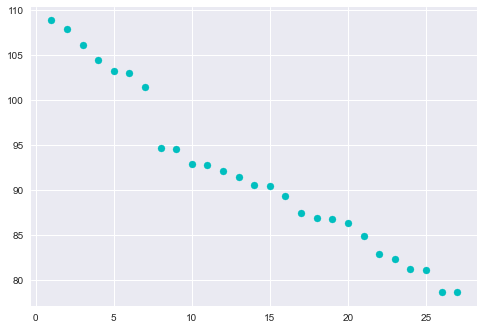

In [40]:
fig, ax = plt.subplots()
ax.scatter(reordered_analysis1_df['Rank'], reordered_analysis1_df['Pass_Rating'],c='c');

In [41]:
model = KMeans(n_clusters=6,random_state=42).fit(reordered_analysis1_df)
model.cluster_centers_

array([[  2.        , 107.58174603],
       [ 19.        ,  86.4625    ],
       [ 10.        ,  93.38464286],
       [ 24.5       ,  80.81944444],
       [  5.5       , 103.003125  ],
       [ 14.5       ,  90.43125   ]])

In [42]:
predicted_clusters = model.predict(reordered_analysis1_df)
predicted_clusters

array([0, 0, 0, 4, 4, 4, 4, 2, 2, 2, 2, 2, 5, 5, 5, 5, 1, 1, 1, 1, 1, 3,
       3, 3, 3, 3, 3])

In [43]:
pre_labeled_df = reordered_analysis1_df.reset_index()
labeled_df = pd.concat([pre_labeled_df, pd.DataFrame(model.labels_,
                        columns=['Tiers'])], axis=1)
labeled_df['Tiers'].replace({0:1,4:2,2:3,5:4,1:4,3:5}, inplace=True)
labeled_df.head()

,QB,Rank,Pass_Rating,Tiers
0,Patrick Mahomes,1,108.828571,1
1,Geno Smith,2,107.850000,1
2,Tua Tagovailoa,3,106.066667,1
3,Josh Allen,4,104.400000,2
4,Joe Burrow,5,103.212500,2


In [44]:
pred_tiers = np.array(labeled_df['Tiers'])
X=reordered_analysis1_df['Rank']
y=reordered_analysis1_df['Pass_Rating']

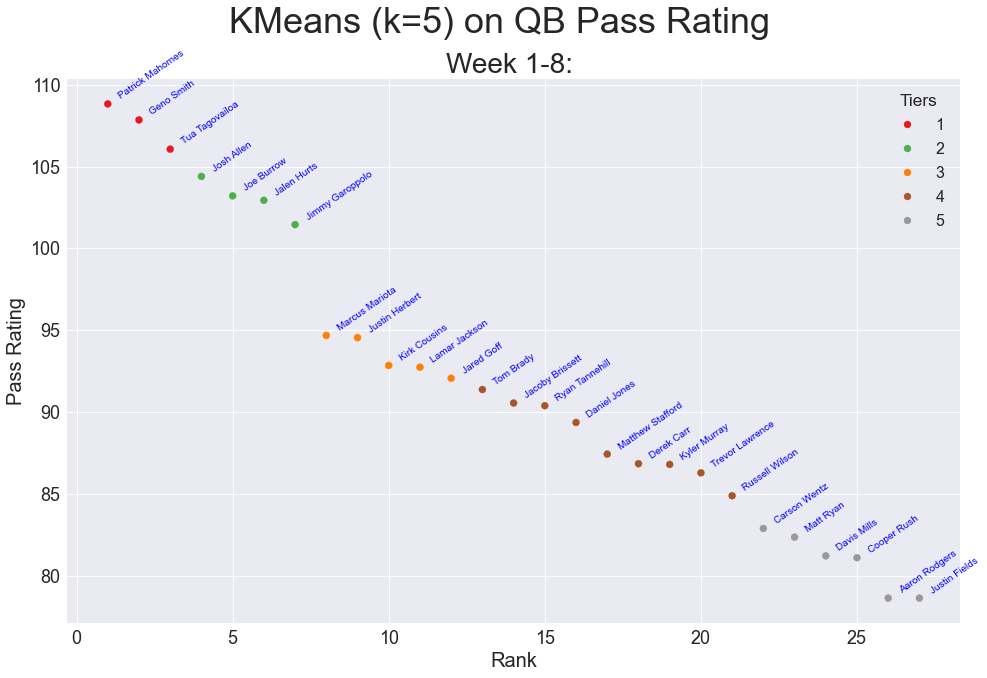

In [45]:
plt.figure(figsize=(16,10))
sc = plt.scatter(X, y, c=pred_tiers,s=50,cmap='Set1')
plt.suptitle('KMeans (k=5) on QB Pass Rating', fontsize=36)
plt.title('Week 1-8: ', fontsize=28);
plt.xlabel('Rank',fontsize=20)
plt.ylabel('Pass Rating',fontsize=20)
plt.tick_params(axis="x", labelsize=18)
plt.tick_params(axis="y", labelsize=18)
for i in range(reordered_analysis1_df.shape[0]):
    plt.text(x=reordered_analysis1_df.Rank[i]+0.3,y=reordered_analysis1_df.Pass_Rating[i]+0.3,s=analysis1_df.index[i], 
          fontdict=dict(color='blue',size=10),rotation=35)
plt.legend(*sc.legend_elements(), title='Tiers', fontsize=16, title_fontsize='xx-large');

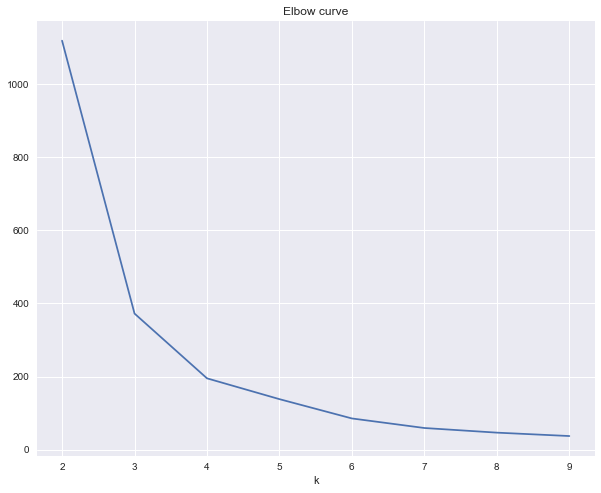

In [46]:
# Specifying the dataset and initializing variables
X = reordered_analysis1_df
distortions = []

# Calculate SSE for different K
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=301)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

# Plot values of SSE
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Elbow curve')
ax.set_xlabel('k')
ax.plot(range(2, 10), distortions)
ax.grid(True)

## ANALYSIS 2: TOTAL YARDS BY QB (Pass + Rush)

In [47]:
data2 = {'QB':['Geno Smith', 'Lamar Jackson', 'Trevor Lawrence', 'Daniel Jones', 'Marcus Mariota', 'Tom Brady',
                  'Justin Fields', 'Jacoby Brissett', 'Aaron Rodgers', 'Kyler Murray', 'Joe Burrow', 'Russell Wilson',
                  'Kirk Cousins', 'Matthew Stafford', 'Matt Ryan', 'Justin Herbert', 'Jimmy Garoppolo', 'Jared Goff',
                  'Patrick Mahomes', 'Josh Allen', 'Derek Carr', 'Jalen Hurts', 'Davis Mills', 'Cooper Rush',
                  'Ryan Tannehill', 'Carson Wentz', 'Tua Tagovailoa'],
        'Total_Yds':[genosmith_df['total_yds'].sum(),lamarjackson_df['total_yds'].sum(),trevorlawrence_df['total_yds'].sum(),
                danieljones_df['total_yds'].sum(),marcusmariota_df['total_yds'].sum(),tombrady_df['total_yds'].sum(),
                justinfields_df['total_yds'].sum(),jacobybrissett_df['total_yds'].sum(),aaronrodgers_df['total_yds'].sum(),
                kylermurray_df['total_yds'].sum(),joeburrow_df['total_yds'].sum(),russellwilson_df['total_yds'].sum(),
                kirkcousins_df['total_yds'].sum(),mattstafford_df['total_yds'].sum(),mattryan_df['total_yds'].sum(),
                justinherbert_df['total_yds'].sum(),jimmygaroppolo_df['total_yds'].sum(),jaredgoff_df['total_yds'].sum(),
                patmahomes_df['total_yds'].sum(),joshallen_df['total_yds'].sum(),derekcarr_df['total_yds'].sum(),
                jalenhurts_df['total_yds'].sum(),davismills_df['total_yds'].sum(),cooperrush_df['total_yds'].sum(),
                ryantannehill_df['total_yds'].sum(),carsonwentz_df['total_yds'].sum(),tuatagovailoa_df['total_yds'].sum()]}
analysis2_df = pd.DataFrame(data2)
analysis2_df.sort_values('Total_Yds', ascending=False, inplace=True)
analysis2_df.reset_index(drop=True,inplace=True)
analysis2_df['Rank']=analysis2_df.index+1
analysis2_df.set_index('QB', inplace=True)
analysis2_df.head()
reordered_analysis2_df = analysis2_df[['Rank','Total_Yds']]
reordered_analysis2_df.head()

,Rank,Total_Yds
QB,,
Josh Allen,1,2504
Joe Burrow,2,2461
Kyler Murray,3,2292
Patrick Mahomes,4,2272
Tom Brady,5,2262


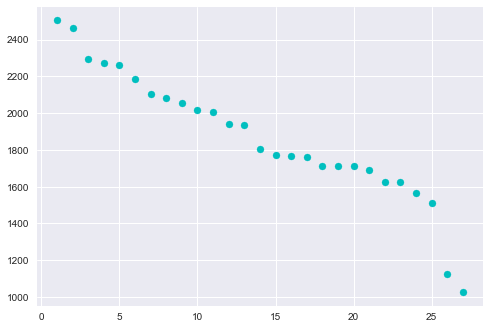

In [48]:
fig, ax = plt.subplots()
ax.scatter(reordered_analysis2_df['Rank'], reordered_analysis2_df['Total_Yds'],c='c');

In [49]:
model = KMeans(n_clusters=6,random_state=42).fit(reordered_analysis2_df)
print(model.cluster_centers_)
predicted_clusters = model.predict(reordered_analysis2_df)
print(predicted_clusters)
pre_labeled_df_2 = reordered_analysis2_df.reset_index()
labeled_df_2 = pd.concat([pre_labeled_df_2, pd.DataFrame(model.labels_,
                        columns=['Tiers'])], axis=1)
labeled_df_2['Tiers'].replace({0:1,4:2,3:3,1:4,5:5,2:6}, inplace=True)
print(labeled_df_2.head())
pred_tiers_2 = np.array(labeled_df['Tiers'])
X=reordered_analysis2_df['Rank']
y=reordered_analysis2_df['Total_Yds']

[[1.50000000e+00 2.48250000e+03]
 [1.75000000e+01 1.74237500e+03]
 [2.65000000e+01 1.07600000e+03]
 [1.00000000e+01 2.01957143e+03]
 [4.50000000e+00 2.25350000e+03]
 [2.35000000e+01 1.58150000e+03]]
[0 0 4 4 4 4 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 5 5 5 5 2 2]
                QB  Rank  Total_Yds  Tiers
0       Josh Allen     1       2504      1
1       Joe Burrow     2       2461      1
2     Kyler Murray     3       2292      2
3  Patrick Mahomes     4       2272      2
4        Tom Brady     5       2262      2


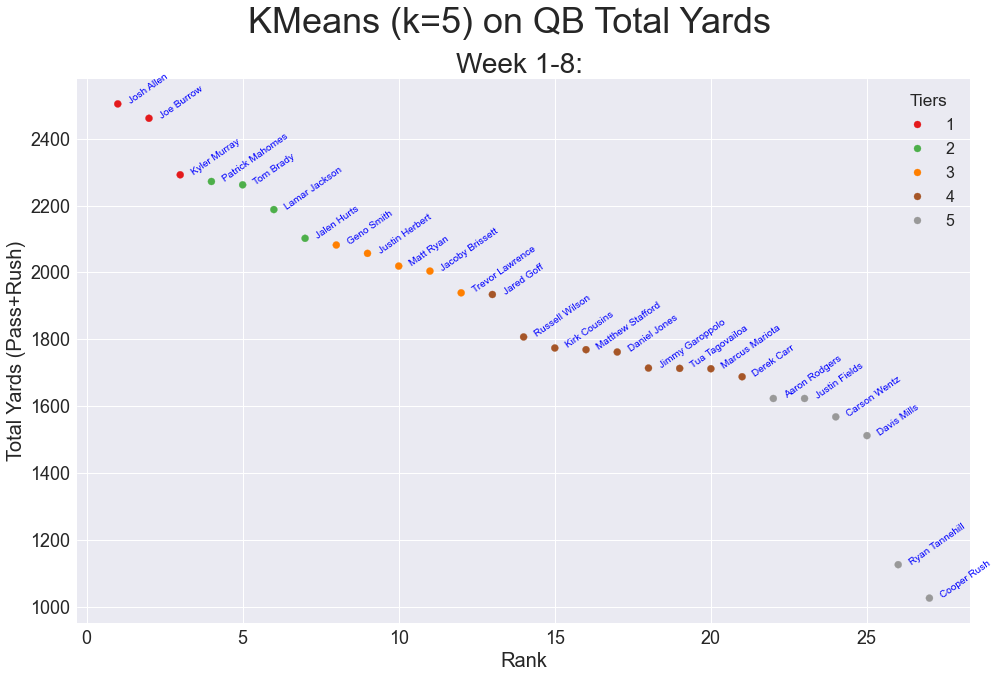

In [50]:
plt.figure(figsize=(16,10))
sc = plt.scatter(X, y, c=pred_tiers,s=50,cmap='Set1')
plt.suptitle('KMeans (k=5) on QB Total Yards', fontsize=36)
plt.title('Week 1-8: ', fontsize=28);
plt.xlabel('Rank',fontsize=20)
plt.ylabel('Total Yards (Pass+Rush)',fontsize=20)
plt.tick_params(axis="x", labelsize=18)
plt.tick_params(axis="y", labelsize=18)
for i in range(reordered_analysis2_df.shape[0]):
    plt.text(x=reordered_analysis2_df.Rank[i]+0.3,y=reordered_analysis2_df.Total_Yds[i]+0.3,s=analysis2_df.index[i], 
          fontdict=dict(color='blue',size=10),rotation=35)
plt.legend(*sc.legend_elements(), title='Tiers', fontsize=16, title_fontsize='xx-large');

## ANALYSIS 3: QB TOTAL TDS (Pass + Rush)

In [51]:
data3 = {'QB':['Geno Smith', 'Lamar Jackson', 'Trevor Lawrence', 'Daniel Jones', 'Marcus Mariota', 'Tom Brady',
                  'Justin Fields', 'Jacoby Brissett', 'Aaron Rodgers', 'Kyler Murray', 'Joe Burrow', 'Russell Wilson',
                  'Kirk Cousins', 'Matthew Stafford', 'Matt Ryan', 'Justin Herbert', 'Jimmy Garoppolo', 'Jared Goff',
                  'Patrick Mahomes', 'Josh Allen', 'Derek Carr', 'Jalen Hurts', 'Davis Mills', 'Cooper Rush',
                  'Ryan Tannehill', 'Carson Wentz', 'Tua Tagovailoa'],
        'Total_TDs':[genosmith_df['total_tds'].sum(),lamarjackson_df['total_tds'].sum(),trevorlawrence_df['total_tds'].sum(),
                danieljones_df['total_tds'].sum(),marcusmariota_df['total_tds'].sum(),tombrady_df['total_tds'].sum(),
                justinfields_df['total_tds'].sum(),jacobybrissett_df['total_tds'].sum(),aaronrodgers_df['total_tds'].sum(),
                kylermurray_df['total_tds'].sum(),joeburrow_df['total_tds'].sum(),russellwilson_df['total_tds'].sum(),
                kirkcousins_df['total_tds'].sum(),mattstafford_df['total_tds'].sum(),mattryan_df['total_tds'].sum(),
                justinherbert_df['total_tds'].sum(),jimmygaroppolo_df['total_tds'].sum(),jaredgoff_df['total_tds'].sum(),
                patmahomes_df['total_tds'].sum(),joshallen_df['total_tds'].sum(),derekcarr_df['total_tds'].sum(),
                jalenhurts_df['total_tds'].sum(),davismills_df['total_tds'].sum(),cooperrush_df['total_tds'].sum(),
                ryantannehill_df['total_tds'].sum(),carsonwentz_df['total_tds'].sum(),tuatagovailoa_df['total_tds'].sum()]}
analysis3_df = pd.DataFrame(data3)
analysis3_df.sort_values('Total_TDs', ascending=False, inplace=True)
analysis3_df.reset_index(drop=True,inplace=True)
analysis3_df['Rank']=analysis3_df.index+1
analysis3_df.set_index('QB', inplace=True)
analysis3_df.head()
reordered_analysis3_df = analysis3_df[['Rank','Total_TDs']]
reordered_analysis3_df.head()

,Rank,Total_TDs
QB,,
Josh Allen,1,21
Patrick Mahomes,2,20
Joe Burrow,3,20
Lamar Jackson,4,17
Jalen Hurts,5,16


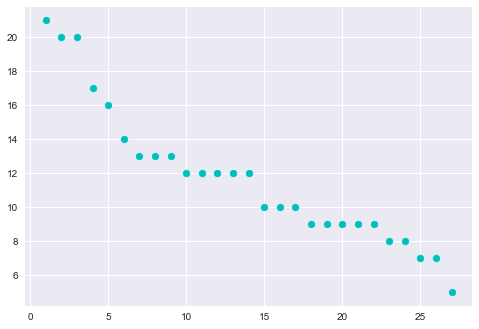

In [52]:
fig, ax = plt.subplots()
ax.scatter(reordered_analysis3_df['Rank'], reordered_analysis3_df['Total_TDs'],c='c');

In [53]:
model = KMeans(n_clusters=5,random_state=42).fit(reordered_analysis3_df)
print(model.cluster_centers_)
predicted_clusters = model.predict(reordered_analysis3_df)
print(predicted_clusters)
pre_labeled_df_3 = reordered_analysis3_df.reset_index()
labeled_df_3 = pd.concat([pre_labeled_df_3, pd.DataFrame(model.labels_,
                        columns=['Tiers'])], axis=1)
labeled_df_3['Tiers'].replace({4:1,0:2,2:3,3:4,5:5,1:6}, inplace=True)
print(labeled_df_3.head())
pred_tiers_3 = np.array(labeled_df['Tiers'])
X=reordered_analysis3_df['Rank']
y=reordered_analysis3_df['Total_TDs']

[[ 7.         13.8       ]
 [24.5         7.33333333]
 [12.         12.        ]
 [18.          9.42857143]
 [ 2.5        19.5       ]]
[4 4 4 4 0 0 0 0 0 2 2 2 2 2 3 3 3 3 3 3 3 1 1 1 1 1 1]
                QB  Rank  Total_TDs  Tiers
0       Josh Allen     1         21      1
1  Patrick Mahomes     2         20      1
2       Joe Burrow     3         20      1
3    Lamar Jackson     4         17      1
4      Jalen Hurts     5         16      2


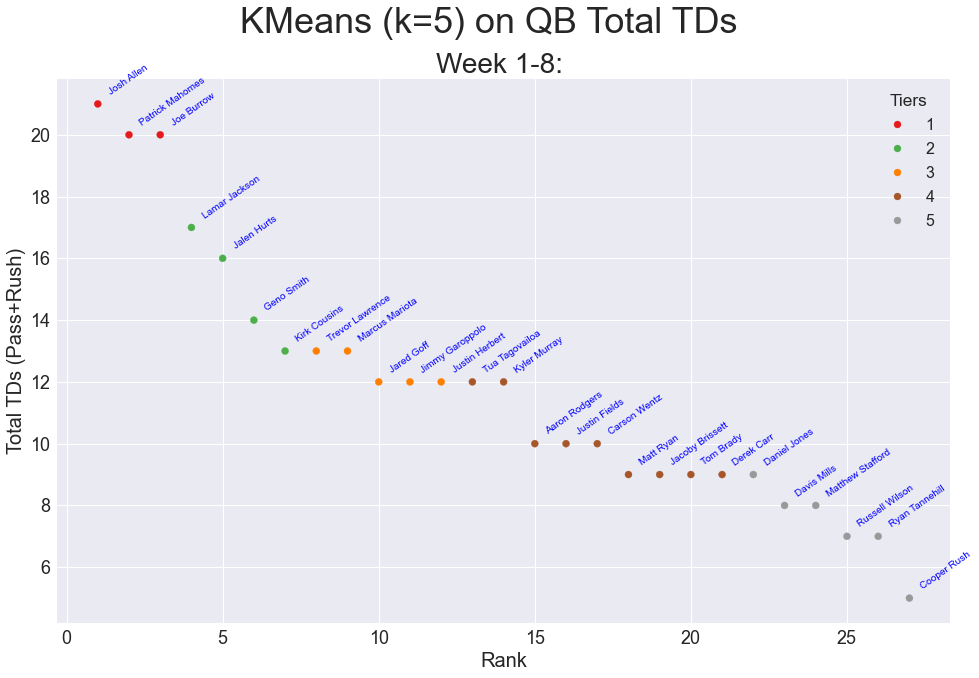

In [54]:
plt.figure(figsize=(16,10))
sc = plt.scatter(X, y, c=pred_tiers,s=50,cmap='Set1')
plt.suptitle('KMeans (k=5) on QB Total TDs', fontsize=36)
plt.title('Week 1-8: ', fontsize=28);
plt.xlabel('Rank',fontsize=20)
plt.ylabel('Total TDs (Pass+Rush)',fontsize=20)
plt.tick_params(axis="x", labelsize=18)
plt.tick_params(axis="y", labelsize=18)
for i in range(reordered_analysis3_df.shape[0]):
    plt.text(x=reordered_analysis3_df.Rank[i]+0.3,y=reordered_analysis3_df.Total_TDs[i]+0.3,s=analysis3_df.index[i], 
          fontdict=dict(color='blue',size=10),rotation=35)
plt.legend(*sc.legend_elements(), title='Tiers', fontsize=16, title_fontsize='xx-large');

In [55]:
# Look into API and CI/CD